# Machine Learning Trading Bot

## Background
- Three machine learning models were utilized to train and predict the trading data sourced from Alpaca API. 
- The target was determined to be the entry price plus 3 times the Average True Range(ATR): '1'.
- The stop was determined to be the entry price minus the Average True Range (ATR): '-1'. 
- Support Vector Machine (SVM), Decision Tree models, and Stochasstic Gradient Descent (SGD) were applied to this data.

In [1]:
# initial imports
from pathlib import Path 
import numpy as np
import matplotlib.pyplot as plt 
from finta import TA

import pandas as pd 
import hvplot.pandas
from pandas.tseries.offsets import DateOffset

import alpaca_trade_api as tradeapi

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn import svm

from imblearn.under_sampling import RandomUnderSampler

### Download stock time-series data from Alpaca API into Pandas DataFrame

In [2]:
# # THE FOLLOWING IS TO REQUEST IN DATA USING THE ALPACA_API
# # API credentials
# API_KEY = 'PKETI0Q5C8PPUXVNHJFJ'
# SECRET_KEY = 'WQxmEpBCoMXydCCg0G8cUe6hGLpgaAfrvedZ09Fy'
# API_BASE_URL = "https://paper-api.alpaca.markets"

# # Create a connection to the API 
# api = tradeapi.REST(API_KEY, SECRET_KEY, API_BASE_URL, api_version="v2")
    
# # Set the ticket symbol and the number of shares to buy
# ticker = "AAPL"

# # Make API call
# signals_df = api.get_bars(ticker, "5Min", "2022-01-01", "2023-08-30", adjustment='raw').df

# # Save the DataFrame with the date index
# signals_df.to_csv('signals_df.csv')

# # create a seperate dataframe for signals
# signals_df

### Read in stock time-series data from .csv file into Pandas DataFrame

In [3]:
# Set ticker
ticker = "AAPL"

# Load the DataFrame from a CSV file
signals_df = pd.read_csv('signals_df.csv', index_col="timestamp")

# Convert the first column (assuming it contains datetime-like values) to DatetimeIndex
signals_df.index = pd.to_datetime(signals_df.index)

signals_df

,open,high,low,close,volume,trade_count,vwap
timestamp,,,,,,,
2022-01-03 09:00:00+00:00,178.26,178.34,178.15,178.15,6894,235,178.243947
2022-01-03 09:05:00+00:00,178.20,178.20,177.76,177.99,4767,186,177.958045
2022-01-03 09:10:00+00:00,177.91,178.08,177.90,178.08,3598,120,177.952941
2022-01-03 09:15:00+00:00,178.08,178.12,177.81,177.86,8398,207,177.998975
2022-01-03 09:20:00+00:00,178.02,178.02,178.00,178.00,1369,72,178.007063
...,...,...,...,...,...,...,...
2023-08-30 23:35:00+00:00,187.65,187.66,187.65,187.66,5373,110,187.654376
2023-08-30 23:40:00+00:00,187.65,187.66,187.64,187.64,6379,124,187.656366
2023-08-30 23:45:00+00:00,187.65,187.65,187.63,187.65,1380,68,187.640261


<Axes: title={'center': 'AAPL Closing Prices'}, xlabel='Timestamp', ylabel='Closing Price'>

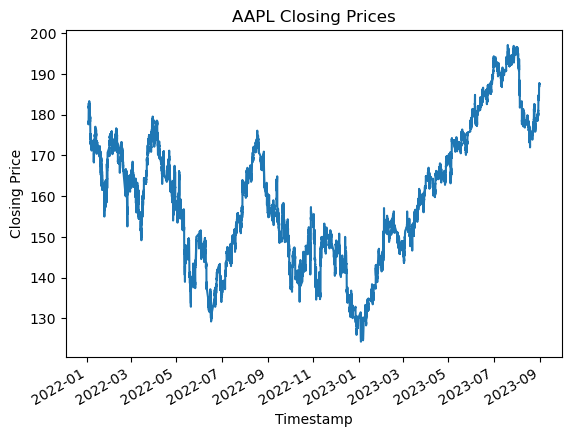

In [4]:
# plot closing prices
signals_df['close'].plot(title=f'{ticker} Closing Prices', xlabel="Timestamp", ylabel='Closing Price')
# plt.savefig(f'{ticker}_closing_prices', facecolor='white', edgecolor='white', transparent='false')

### Add Features (Techincal Analysis Indicators) to the DataFrame

In [5]:
# continuous features (techinal indicators) may be used
features = ["volume", "trade_count", "vwap", "9EMA", "20EMA", "50EMA", "200SMA", "ATR", "RSI", "BB_UPPER", "BB_LOWER", "MACD"]

#  Setup EMAs for crosses
longest_MA_window = 200
signals_df["9EMA"] = TA.EMA(signals_df, 9)
signals_df["20EMA"] = TA.EMA(signals_df, 20)
signals_df["50EMA"] = TA.EMA(signals_df, 50)
signals_df["200SMA"] = TA.SMA(signals_df, longest_MA_window)

# Setup Indicators
signals_df["ATR"] = TA.ATR(signals_df)
bbands_df = TA.BBANDS(signals_df)
macd_df = TA.MACD(signals_df)
signals_df["RSI"] = TA.RSI(signals_df)

# join macd and bbands Dataframes to signals_df
bbands_df = pd.concat([bbands_df, macd_df], axis=1)
signals_df = pd.concat([signals_df, bbands_df], axis=1)
signals_df.drop(columns="SIGNAL", inplace=True)

# Exit is the labeled target for ML, Exit Price is for use in Pnl Metrics
signals_df["Exit Price"] = 0
signals_df["Exit"] = 0

# Review DataFrame
signals_df.head()

,open,high,low,close,volume,trade_count,vwap,9EMA,20EMA,50EMA,200SMA,ATR,RSI,BB_UPPER,BB_MIDDLE,BB_LOWER,MACD,Exit Price,Exit
timestamp,,,,,,,,,,,,,,,,,,,
2022-01-03 09:00:00+00:00,178.26,178.34,178.15,178.15,6894,235,178.243947,178.150000,178.150000,178.150000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0,0
2022-01-03 09:05:00+00:00,178.20,178.20,177.76,177.99,4767,186,177.958045,178.061111,178.066000,178.068400,NaN,NaN,0.000000,NaN,NaN,NaN,-0.003590,0,0
2022-01-03 09:10:00+00:00,177.91,178.08,177.90,178.08,3598,120,177.952941,178.068852,178.071141,178.072422,NaN,NaN,37.724551,NaN,NaN,NaN,-0.001783,0,0
2022-01-03 09:15:00+00:00,178.08,178.12,177.81,177.86,8398,207,177.998975,177.998103,178.010188,178.016089,NaN,NaN,18.927664,NaN,NaN,NaN,-0.008861,0,0
2022-01-03 09:20:00+00:00,178.02,178.02,178.00,178.00,1369,72,178.007063,177.998667,178.007723,178.012609,NaN,NaN,39.564532,NaN,NaN,NaN,-0.006949,0,0


### Create Volatility Based Targets and Stops

In [6]:
# here we create the exit column, our "y", for use in supervised ML
# How many rows are in the signals_df? for use in modifying DataFrame
num_rows_in_df = signals_df.shape[0]

# reward:risk ratio
reward = 3
risk = 1

# we also figure out our exit price
# hitting target price before the stop price signals a win and will be 1
# hitting stop price before hitting the target price signals a loss and will be -1
# loop thru the dataframe, from the longest_MA_window to the end (num_rows_in_df) to avoid NaN values
for j in range(longest_MA_window, num_rows_in_df):
    # entries will be on candle close
    entry = signals_df["close"].iloc[j]
    # calculate volatility for each candle
    atr = signals_df["ATR"].iloc[j]
    # stop is entry price minus the average volatility for the entry period
    stop = entry - (risk * atr)
    # target is entry price plus the average volatility for the entry period times a multiplier
    target = entry + (reward * atr)
    # loop again thru the dataset to compare j entry price to future closing prices to see if we hit target or stop
    for k in range(j + 1, num_rows_in_df):
        # current low of the candle
        curr_low = signals_df["low"].iloc[k]
        # current high of the candle
        curr_high = signals_df["high"].iloc[k]
        # record and break if we hit stop or target, if not we check the next k period
        # if current low breaks our stop we should've sold: -1 in our "Exit" column
        if curr_low <= stop:
            signals_df["Exit Price"].iloc[j] = stop
            signals_df["Exit"].iloc[j] = -1
            # if we hit the stop break the inner loop to check the next row
            break
        # if current high breaks our target we should've sold: +1 in our "Exit" column
        elif curr_high >= target:
            signals_df["Exit Price"].iloc[j] = target
            signals_df["Exit"].iloc[j] = 1
            # if we hit the target break the inner loop to check the next row
            break

# drop beginning columns to avoid NaN values from EMA/SMA calculations
signals_df = signals_df[longest_MA_window:]

signals_df

C:\Users\range\AppData\Local\Temp\ipykernel_2116\2754806154.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  signals_df["Exit Price"].iloc[j] = target
C:\Users\range\AppData\Local\Temp\ipykernel_2116\2754806154.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  signals_df["Exit"].iloc[j] = 1
C:\Users\range\AppData\Local\Temp\ipykernel_2116\2754806154.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  signals_df["Exit"].iloc[j] 

,open,high,low,close,volume,trade_count,vwap,9EMA,20EMA,50EMA,200SMA,ATR,RSI,BB_UPPER,BB_MIDDLE,BB_LOWER,MACD,Exit Price,Exit
timestamp,,,,,,,,,,,,,,,,,,,
2022-01-04 09:40:00+00:00,182.61,182.87,182.60,182.87,7550,183,182.697110,182.515386,182.316310,182.138213,180.613574,0.163564,76.956011,182.863656,182.184990,181.506324,0.180654,183.360693,1
2022-01-04 09:45:00+00:00,182.85,182.85,182.72,182.75,1925,81,182.759138,182.562309,182.357614,182.162212,180.637374,0.167850,69.636808,182.931951,182.231490,181.531029,0.191817,183.253550,1
2022-01-04 09:50:00+00:00,182.80,182.81,182.78,182.78,1970,73,182.794741,182.605847,182.397841,182.186446,180.660874,0.163571,70.394884,183.001451,182.272495,181.543539,0.200769,183.270714,1
2022-01-04 09:55:00+00:00,182.78,182.95,182.78,182.87,3579,144,182.873537,182.658678,182.442808,182.213260,180.685924,0.165000,72.604658,183.072854,182.321995,181.571136,0.212674,183.365000,1
2022-01-04 10:00:00+00:00,182.89,182.96,182.84,182.96,5728,114,182.877489,182.718942,182.492065,182.242552,180.710724,0.167143,74.642942,183.151934,182.373495,181.595056,0.226758,182.792857,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-30 23:35:00+00:00,187.65,187.66,187.65,187.66,5373,110,187.654376,187.642631,187.638313,187.558656,186.068938,0.022179,55.497073,187.677389,187.646000,187.614611,0.010624,187.637821,-1
2023-08-30 23:40:00+00:00,187.65,187.66,187.64,187.64,6379,124,187.656366,187.642105,187.638473,187.561846,186.084288,0.022179,51.702308,187.676939,187.645500,187.614061,0.009664,187.617821,-1
2023-08-30 23:45:00+00:00,187.65,187.65,187.63,187.65,1380,68,187.640261,187.643684,187.639571,187.565303,186.099688,0.020714,53.417422,187.677389,187.646000,187.614611,0.009600,187.629286,-1


### Data Cleaning

In [7]:
# remove all unwanted zeros from the exit column
signals_df = signals_df.loc[signals_df["Exit"] != 0]

# Define NYSE regular trading hours
nyse_opening_time = pd.Timestamp("09:30:00")
nyse_closing_time = pd.Timestamp("16:00:00")

# Filter the DataFrame to include only data within NYSE regular trading hours
signals_df = signals_df.between_time(nyse_opening_time.time(), nyse_closing_time.time())

# # include only higher than average volume
# signals_df = signals_df[signals_df["volume"] >= signals_df["volume"].mean()]

# make sure we have a sufficient training period
training_begin = str(signals_df.index.min())
training_end = str(signals_df.index.min() + DateOffset(months=6))

signals_df

,open,high,low,close,volume,trade_count,vwap,9EMA,20EMA,50EMA,200SMA,ATR,RSI,BB_UPPER,BB_MIDDLE,BB_LOWER,MACD,Exit Price,Exit
timestamp,,,,,,,,,,,,,,,,,,,
2022-01-04 09:40:00+00:00,182.6100,182.870,182.60,182.8700,7550,183,182.697110,182.515386,182.316310,182.138213,180.613574,0.163564,76.956011,182.863656,182.184990,181.506324,0.180654,183.360693,1
2022-01-04 09:45:00+00:00,182.8500,182.850,182.72,182.7500,1925,81,182.759138,182.562309,182.357614,182.162212,180.637374,0.167850,69.636808,182.931951,182.231490,181.531029,0.191817,183.253550,1
2022-01-04 09:50:00+00:00,182.8000,182.810,182.78,182.7800,1970,73,182.794741,182.605847,182.397841,182.186446,180.660874,0.163571,70.394884,183.001451,182.272495,181.543539,0.200769,183.270714,1
2022-01-04 09:55:00+00:00,182.7800,182.950,182.78,182.8700,3579,144,182.873537,182.658678,182.442808,182.213260,180.685924,0.165000,72.604658,183.072854,182.321995,181.571136,0.212674,183.365000,1
2022-01-04 10:00:00+00:00,182.8900,182.960,182.84,182.9600,5728,114,182.877489,182.718942,182.492065,182.242552,180.710724,0.167143,74.642942,183.151934,182.373495,181.595056,0.226758,182.792857,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-30 15:40:00+00:00,187.1700,187.330,187.10,187.2100,520662,5116,187.198690,186.830807,186.541878,185.813747,184.420685,0.328286,67.177962,187.399987,186.693815,185.987643,0.377653,186.881714,-1
2023-08-30 15:45:00+00:00,187.2100,187.225,187.02,187.0421,410374,4126,187.151151,186.873065,186.589518,185.861918,184.444421,0.319536,62.963941,187.427880,186.705920,185.983960,0.372727,186.722564,-1
2023-08-30 15:50:00+00:00,187.0500,187.080,186.95,187.0000,483145,4889,187.011434,186.898452,186.628611,185.906548,184.466871,0.296000,61.915164,187.273647,186.674810,186.075973,0.361262,186.704000,-1


### Split the data into training and testing sets.

In [8]:
# choose features
X = signals_df[features]

# 1 means a buy would've produced a profit (hit target/win), -1 means a sale would've produced a profit (his stop/loss)
y = signals_df["Exit"]
y.head()

timestamp
2022-01-04 09:40:00+00:00    1
2022-01-04 09:45:00+00:00    1
2022-01-04 09:50:00+00:00    1
2022-01-04 09:55:00+00:00    1
2022-01-04 10:00:00+00:00   -1
Name: Exit, dtype: int64

In [9]:
# Splitting into Train and Test sets
X_train = X.loc[training_begin: training_end]
y_train = y.loc[training_begin: training_end]

# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end:]
y_test = y.loc[training_end:]
# X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5)

In [10]:
# Scale the data
scaler = StandardScaler()
X_scaler = scaler.fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [11]:
# Undersample the data
rus = RandomUnderSampler(random_state=1)
undersampled_X_train_scaled, undersampled_y_train = rus.fit_resample(X_train_scaled, y_train)

### Support Vector Machine (SVC) Model

In [12]:
# Create the classifier model
model = svm.SVC(probability=True, random_state=1)
 
# Fit the model to the data using undersampled_X_train_scaled and undersampled_y_train
model = model.fit(undersampled_X_train_scaled, undersampled_y_train)

# Use the trained model to predict the trading signals for the training data
training_signal_predictions = model.predict(undersampled_X_train_scaled)
training_probability_estimates = model.predict_proba(undersampled_X_train_scaled)

In [13]:
# Evaluate the model using a classification report
training_report = classification_report(undersampled_y_train, training_signal_predictions)
print(training_report)

              precision    recall  f1-score   support

          -1       0.59      0.62      0.60      2292
           1       0.60      0.56      0.58      2292

    accuracy                           0.59      4584
   macro avg       0.59      0.59      0.59      4584
weighted avg       0.59      0.59      0.59      4584



In [14]:
# Use the trained model to predict the trading signals for the testing data.
testing_signal_predictions = model.predict(X_test_scaled)
testing_probability_estimates = model.predict_proba(X_test_scaled)

In [15]:
# Evaluate the model's ability to predict the trading signal for the testing data
testing_report = classification_report(y_test, testing_signal_predictions)
print(testing_report)

              precision    recall  f1-score   support

          -1       0.75      0.67      0.71     16418
           1       0.28      0.36      0.31      5794

    accuracy                           0.59     22212
   macro avg       0.51      0.51      0.51     22212
weighted avg       0.63      0.59      0.61     22212



### Visualization

In [16]:
# Create a predictions DataFrame for SVM
predictions_df = pd.DataFrame(index=X_test.index)

predictions_df["predicted_signal"] = testing_signal_predictions

predictions_df["actual_returns"] = signals_df["close"].pct_change()

predictions_df["algo_returns"] = (signals_df["Exit Price"] - signals_df["close"])/signals_df["close"]


predictions_df["trading_algorithm_returns"] = (
    predictions_df["algo_returns"] * predictions_df["predicted_signal"]
)

predictions_df = predictions_df.drop(columns=["algo_returns"])

predictions_df["probability_estimates"] = testing_probability_estimates[:, 1]

# Filter rows where the predicted signal is 1 and the probability estimate is >= 0.60
buy_signals_df = predictions_df[(predictions_df["predicted_signal"] == 1) & (predictions_df["probability_estimates"] >= 0.50)]


### Evaluation Metrics

In [17]:
# Calculate the time period for which you want to calculate the frequency (e.g., in days)
start_date = buy_signals_df.index.min()
end_date = buy_signals_df.index.max()
time_period_days = (end_date - start_date).days + 1  # Adding 1 to include both start and end dates

# Filter the winning, losing, and total trades
winning_trades = buy_signals_df[buy_signals_df['trading_algorithm_returns'] > 0]
losing_trades = buy_signals_df[buy_signals_df['trading_algorithm_returns'] < 0]
total_trades = buy_signals_df["trading_algorithm_returns"]

# Calculate gross profit (positive returns) and gross loss (negative returns)
gross_profit = buy_signals_df[buy_signals_df['trading_algorithm_returns'] > 0]['trading_algorithm_returns'].sum() * 100
gross_loss = buy_signals_df[buy_signals_df['trading_algorithm_returns'] < 0]['trading_algorithm_returns'].sum() * 100

# Calculate the average return of your trading strategy
average_return = buy_signals_df['trading_algorithm_returns'].mean()

# Calculate the risk-free rate (e.g., Treasury bill rate)
# You need to specify an appropriate risk-free rate for your analysis
risk_free_rate = 0.02  # Replace with the risk-free rate you want to use (e.g., 2% for a Treasury bill)

# Calculate downside returns (negative returns)
downside_returns = buy_signals_df['trading_algorithm_returns'][buy_signals_df['trading_algorithm_returns'] < 0]

# Calculate the downside deviation (standard deviation of negative returns)
downside_deviation = (downside_returns * 100).std()

# Calculate the Risk:Reward Ratio
risk_reward_ratio= reward/risk

# Calculate the win rate (if you haven't already)
win_rate = len(winning_trades) / len(total_trades)

# Calculate the profit factor
profit_factor = abs(gross_profit / gross_loss)

# Calculate the Sortino Ratio
sortino_ratio = (average_return - risk_free_rate) / downside_deviation

# Calculate the average profit per winning trade
average_profit_per_winning_trade = winning_trades['trading_algorithm_returns'].mean()

# Calculate the average loss per losing trade
average_loss_per_losing_trade = losing_trades['trading_algorithm_returns'].mean()

# Calculate the trade frequency (trades per day)
trade_frequency_per_day = len(total_trades) / time_period_days

# Calculate the volatility of your trading strategy's returns
algo_volatility = buy_signals_df['trading_algorithm_returns'].std()

# Calculate the cumulative returns of the algo
cumulative_returns = ( 1 + buy_signals_df['trading_algorithm_returns']).sum()

# Print the sorted metrics by importance
print("Risk:Reward Ratio:", risk_reward_ratio)
print("Win Rate (%):", win_rate * 100)
print("Profit Factor:", profit_factor)
print("Sortino Ratio:", sortino_ratio)
print("Average Profit per Winning Trade (%):", average_profit_per_winning_trade * 100)
print("Average Loss per Losing Trade (%):", average_loss_per_losing_trade * 100)
print("Average Return (%):", average_return * 100)
print("Trade Frequency (Trades per Day):", trade_frequency_per_day)
print("Downside Deviation:", downside_deviation)
print("Volatility (Standard Deviation of Algo Returns):", algo_volatility)
print("Gross Profit (%):", gross_profit)
print("Gross Loss (%):", gross_loss)
print("Total Number of Winning Trades:", len(winning_trades))
print("Total Number of Trades:", len(total_trades))
print("Risk-Free Rate (%):", risk_free_rate * 100)


Risk:Reward Ratio: 3.0
Win Rate (%): 27.78675282714055
Profit Factor: 1.100286720777277
Sortino Ratio: -0.14672493598180517
Average Profit per Winning Trade (%): 0.5733131099406654
Average Loss per Losing Trade (%): -0.20049655975417627
Average Return (%): 0.014520020516442102
Trade Frequency (Trades per Day): 17.601895734597157
Downside Deviation: 0.13531987362596432
Volatility (Standard Deviation of Algo Returns): 0.004230218052636733
Gross Profit (%): 1183.3182589175333
Gross Loss (%): -1075.4635465214014
Total Number of Winning Trades: 2064
Total Number of Trades: 7428
Risk-Free Rate (%): 2.0


### WIP METRICS

In [18]:
# maximum drawdown (MDD)
# peters ratio
# t-stat
# kelly criterion
# sharpe ratio
# calmar ratio
# pain/gain ratio
# ulcer index
# k-ratio


C:\Users\range\AppData\Local\Temp\ipykernel_2116\466547628.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  buy_signals_df["Cumulative Algo Returns"] = (1 + buy_signals_df["trading_algorithm_returns"]).cumprod()


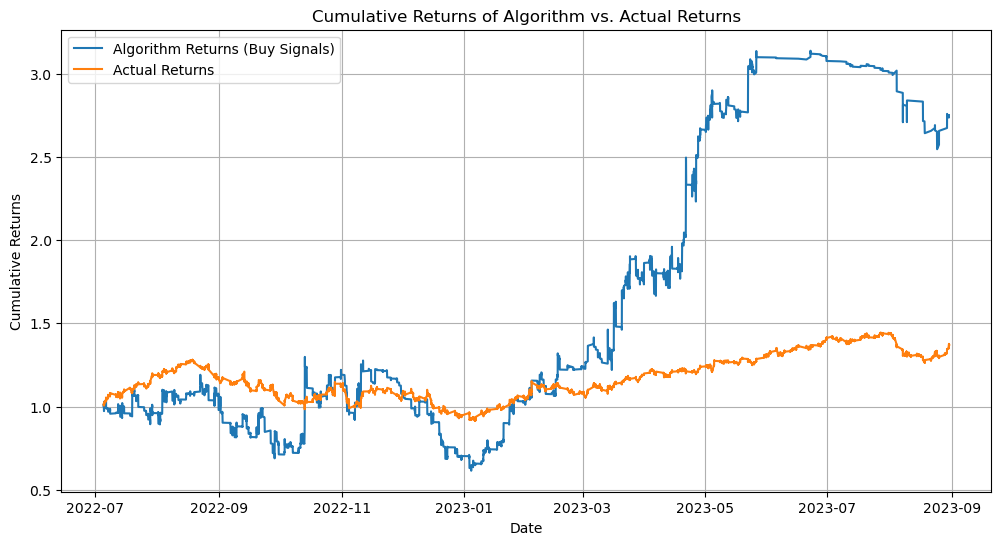

In [19]:
# Calculate cumulative returns for the algorithmic trading strategy
buy_signals_df["Cumulative Algo Returns"] = (1 + buy_signals_df["trading_algorithm_returns"]).cumprod()

# Calculate cumulative returns for the actual stock returns
predictions_df["Cumulative Actual Returns"] = (1 + predictions_df["actual_returns"]).cumprod()

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(buy_signals_df.index, buy_signals_df["Cumulative Algo Returns"], label="Algorithm Returns (Buy Signals)")
plt.plot(predictions_df.index, predictions_df["Cumulative Actual Returns"], label="Actual Returns")
plt.xlabel("Date") 
plt.ylabel("Cumulative Returns")
plt.title("Cumulative Returns of Algorithm vs. Actual Returns")
plt.legend()
plt.grid(True)
plt.show()

In [20]:
buy_signals_df

,predicted_signal,actual_returns,trading_algorithm_returns,probability_estimates,Cumulative Algo Returns
timestamp,,,,,
2022-07-05 09:30:00+00:00,1,0.011972,0.003962,0.625485,1.003962
2022-07-05 09:35:00+00:00,1,0.000508,0.003618,0.631174,1.007595
2022-07-05 09:40:00+00:00,1,0.000942,-0.001174,0.617409,1.006412
2022-07-05 09:45:00+00:00,1,-0.000145,-0.001133,0.622664,1.005272
2022-07-05 09:50:00+00:00,1,0.000072,0.003057,0.627947,1.008344
...,...,...,...,...,...
2023-08-29 15:50:00+00:00,1,0.000273,-0.001429,0.506950,2.746912
2023-08-30 12:20:00+00:00,1,0.000379,-0.001203,0.505206,2.743608
2023-08-30 12:25:00+00:00,1,0.000108,-0.001222,0.508982,2.740255


In [21]:
import pandas as pd

# Assuming your dataframe is named 'buy_signals_df'
# Step 2: Calculate cumulative returns
buy_signals_df['cumulative_returns'] = (1 + buy_signals_df['trading_algorithm_returns']).cumprod()

# Step 3: Calculate the peak
buy_signals_df['peak'] = buy_signals_df['cumulative_returns'].cummax()

# Step 4: Calculate drawdown
buy_signals_df['drawdown'] = buy_signals_df['cumulative_returns'] / buy_signals_df['peak'] - 1

# Step 5: Find the maximum drawdown
max_drawdown = buy_signals_df['drawdown'].min()

print("Maximum Drawdown (MDD): {:.2%}".format(max_drawdown))


Maximum Drawdown (MDD): -52.71%


C:\Users\range\AppData\Local\Temp\ipykernel_2116\958304416.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  buy_signals_df['cumulative_returns'] = (1 + buy_signals_df['trading_algorithm_returns']).cumprod()
C:\Users\range\AppData\Local\Temp\ipykernel_2116\958304416.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  buy_signals_df['peak'] = buy_signals_df['cumulative_returns'].cummax()
C:\Users\range\AppData\Local\Temp\ipykernel_2116\958304416.py:11: SettingWithCopyWarning: 
A value is trying to be set o

In [22]:
# Calculate Kelly Criterion
kelly_criterion = (win_rate * (average_profit_per_winning_trade / abs(average_loss_per_losing_trade))) - ((1 - win_rate) / abs(average_loss_per_losing_trade))

# Calculate Sharpe Ratio (assuming a risk-free rate has already been defined)
sharpe_ratio = (average_return - risk_free_rate) / algo_volatility

# # Calculate Calmar Ratio
# calmar_ratio = (average_return - risk_free_rate) / (drawdown_max / 100)

# Calculate Pain/Gain Ratio
pain_gain_ratio = (average_loss_per_losing_trade * win_rate) / (average_profit_per_winning_trade * (1 - win_rate))

print(kelly_criterion, sharpe_ratio, pain_gain_ratio)

-359.37744849297246 -4.693564149124631 -0.13456619610123247
